# Model Training


In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


max_token_length = 64
word_embedding_dim = 300
model_name = "nlpie/bio-distilbert-uncased"
# model_name = "nlpie/distil-biobert"
# model_name = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preparing Dataset


In [2]:
augmented_data = pd.read_pickle("augmented_labelled_data_word_embedding.pkl")
augmented_data = augmented_data.fillna("")
augmented_data.shape

(45456, 5)

In [3]:
# augmented_data[(augmented_data.Analysis == "80") & (augmented_data.Attribute == "80")].reset_index()
augmented_data.drop(augmented_data.index[(augmented_data.Analysis == "80") & (augmented_data.Attribute == "80")], inplace = True)
augmented_data.shape

(45437, 5)

In [4]:
class BMSDataset(Dataset):
    def __init__(self, encodings, word_embeddings, parent_labels, child_labels):
        self.encodings = encodings
        self.word_embeddings = word_embeddings
        self.parent_labels = parent_labels
        self.child_labels = child_labels

    def __getitem__(self, idx):
        encoding = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        word_embedding = torch.tensor(self.word_embeddings[idx]).to(device)
        parent_label = torch.tensor(self.parent_labels[idx]).to(device)
        child_label = torch.tensor(self.child_labels[idx]).to(device)
        return encoding, word_embedding, parent_label, child_label

    def __len__(self):
        return len(self.child_labels)

parent_label2id = {
  "ce-sds (non-reduced) hhl": 0,
  "ce-sds (non-reduced) purity": 0,
  "ce-sds (reduced) purity": 0,
  "sds-page (non-reduced) purity": 0,
  "sds-page (reduced) purity": 0,
  "ief acidic peaks": 1,
  "ief basic peaks": 1,
  "ief main peak": 1,
  "icief acidic peaks": 1,
  "icief basic peaks": 1,
  "icief main peak": 1,
  "cex acidic peaks": 1,
  "cex basic peaks": 1,
  "cex main peak": 1,
  "aex acidic peaks": 1,
  "aex basic peaks": 1,
  "aex main peak": 1,
  "rp-hplc purity": 2,
  "se-hplc hmw": 2,
  "se-hplc lmw": 2,
  "se-hplc monomer": 2,
  "se-uplc hmw": 2,
  "se-uplc lmw": 2,
  "se-uplc monomer": 2,
  "particulate-matter >= 10-um": 3,
  "particulate-matter >= 25-um": 3,
  "potency by cell-based bioassay": 4,
  "potency by binding elisa": 4,
  "spr binding activity": 4,
  "ph": 5,
  "protein concentration (a280)": 6,
  "polysorbate 80": 7
}
parent_class_count = len(list(set(parent_label2id.values())))
child_class_count = len(parent_label2id.keys())

child_label2id = [{"unknown": 0} for _ in range(parent_class_count)]
for label, group in parent_label2id.items():
    child_label2id[group][label.lower()] = len(child_label2id[group])

child_id2label = [{} for _ in range(parent_class_count)]
for parent_id in range(parent_class_count):
    for label, child_id in child_label2id[parent_id].items():
        child_id2label[parent_id][child_id] = label

parent_labels = [parent_label2id[label.lower()] for label in augmented_data["Standard names"].tolist()]
child_labels = [child_label2id[parent][label.lower()] for parent, label in zip(parent_labels, augmented_data["Standard names"].tolist())]


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
encodings = tokenizer(augmented_data["Analysis"].tolist(), augmented_data["Attribute"].tolist(), max_length=max_token_length, padding="max_length", truncation=True)
encodings.keys()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask'])

In [6]:
train_dataset = BMSDataset(
    encodings=encodings,
    word_embeddings=augmented_data["Embedding"].tolist(),
    parent_labels=parent_labels,
    child_labels=child_labels
)

### Model Definition

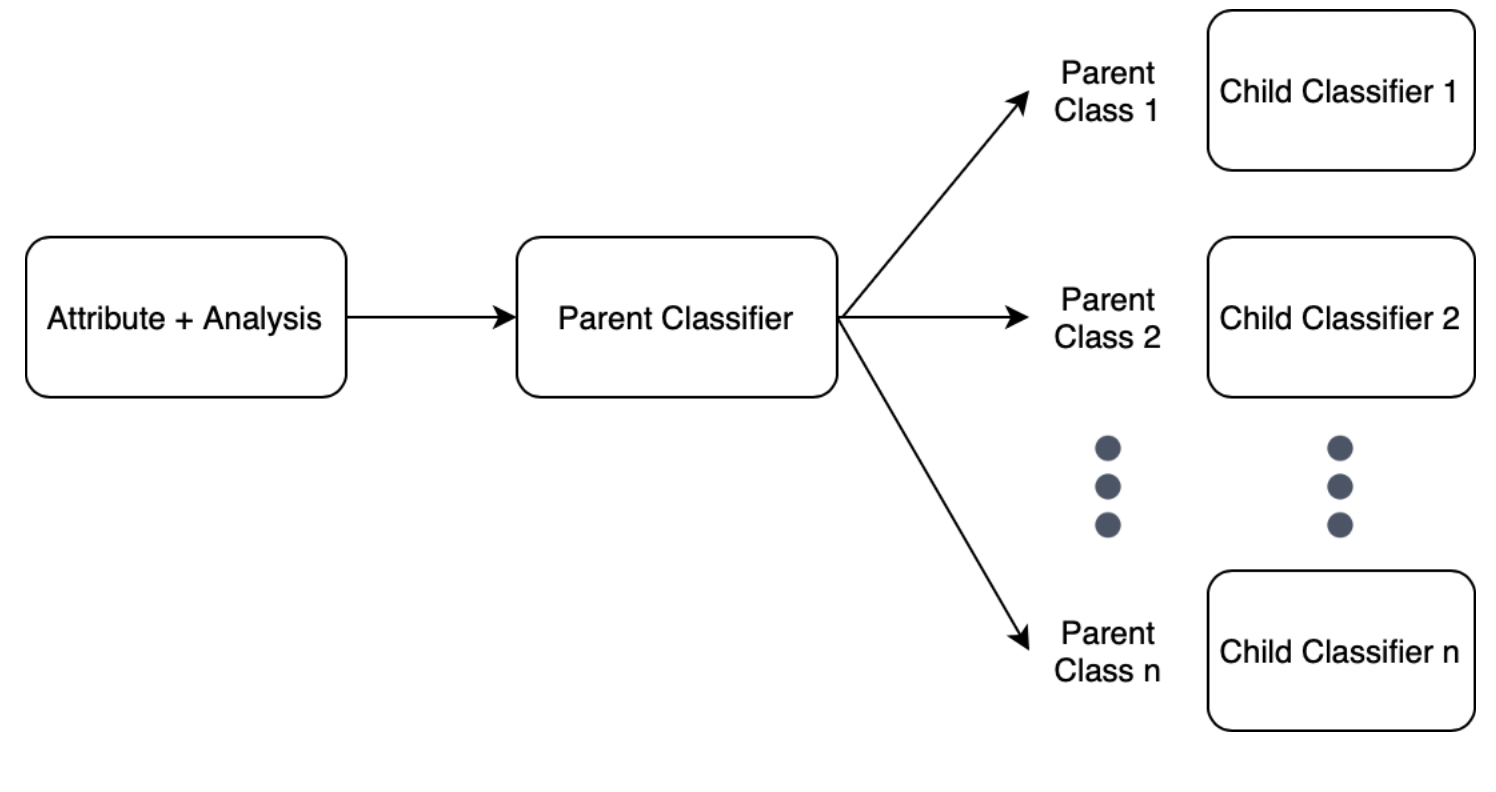

#### Child classifier
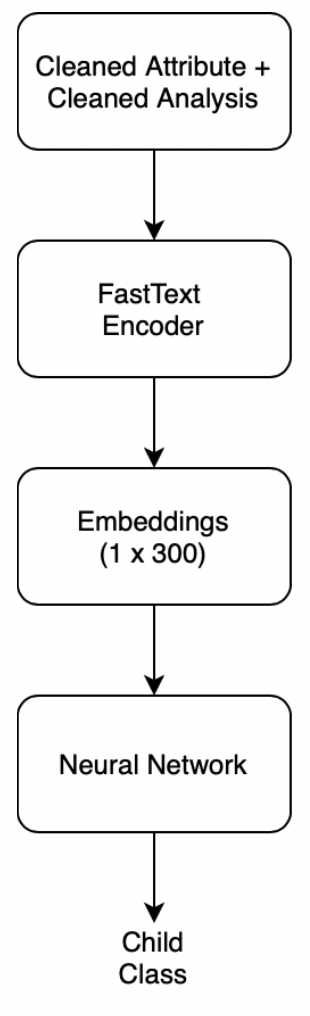

In [7]:
class ChildClassifier(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(ChildClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.classifier(x)

In [8]:
class BMSModel(nn.Module):
    def __init__(self, number_of_child_classifiers: int):
        super(BMSModel, self).__init__()

        self.parent_classifier = AutoModelForSequenceClassification.from_pretrained('./parent_classifier')
        # Freezing the parent classifier
        for param in self.parent_classifier.parameters():
            param.requires_grad = False


        self.child_classifier = nn.ModuleList([])
        for i in range(number_of_child_classifiers):
            self.child_classifier.append(ChildClassifier(input_dim=word_embedding_dim, output_dim=len(child_label2id[i])))


    def get_parent_prediction(self, encodings):
        parent_outputs = self.parent_classifier(**encodings)
        parent_class_probabilities = torch.softmax(parent_outputs.logits, dim=1)
        parent_class_prob, parent_class = torch.max(parent_class_probabilities, dim=1)
        return parent_class_prob, parent_class


    def forward(self, encodings, word_embeddings):
        parent_class_prob, parent_class = self.get_parent_prediction(encodings)

        batch_size = parent_class.size(0)
        child_class_prob = torch.zeros(batch_size, device=device)
        child_class = torch.zeros(batch_size, dtype=torch.long, device=device)

        for parent_id in range(len(self.child_classifier)):
            indices = (parent_class == parent_id).nonzero(as_tuple=True)[0]
            if len(indices) == 0:
                continue

            batch_embeddings = word_embeddings[indices]

            child_outputs = self.child_classifier[parent_id](batch_embeddings)
            child_probabilities = torch.softmax(child_outputs, dim=1)
            prob, cls = torch.max(child_probabilities, dim=1)

            child_class_prob[indices] = prob
            child_class[indices] = cls

        return parent_class, parent_class_prob, child_class, child_class_prob


    def optimize_loss(self, encodings, word_embeddings, parent_label, child_label, optimizer):
        _, parent_class_prediction = self.get_parent_prediction(encodings)

        total_loss = 0.0

        for parent_id in range(len(self.child_classifier)):
            indices = (parent_class_prediction == parent_id).nonzero(as_tuple=True)[0]
            if len(indices) == 0:
                continue

            # Gather inputs for this parent class
            batch_embeddings = word_embeddings[indices]
            batch_child_labels = child_label[indices]
            batch_parent_labels = parent_label[indices]

            # Set child label to 0 where parent label doesn't match
            mismatch_mask = ~torch.eq(batch_parent_labels, parent_id)
            batch_child_labels[mismatch_mask] = 0

            optimizer.zero_grad()
            child_outputs = self.child_classifier[parent_id](batch_embeddings)
            child_loss = F.cross_entropy(child_outputs, batch_child_labels)
            child_loss.backward()
            optimizer.step()

            total_loss += child_loss

        return total_loss



### Training

In [11]:
epochs = 20
batch_size = 128
child_input_dim = max_token_length

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
bms_model = BMSModel(number_of_child_classifiers=parent_class_count)
bms_model.to(device)
optimizer = torch.optim.AdamW(bms_model.parameters(), lr=2e-4)



In [12]:
next(bms_model.child_classifier[1].parameters()).device

device(type='cuda', index=0)

In [ ]:
from tqdm.notebook import tqdm

best_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
no_improvement = 0

for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")
    for encodings, word_embeddings, parent_labels, child_labels in progress_bar:
        loss = bms_model.optimize_loss(
            encodings=encodings,
            word_embeddings=word_embeddings,
            parent_label=parent_labels,
            child_label=child_labels,
            optimizer=optimizer
        )
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss}")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement >= patience:
          print(f"Stopping training early at epoch {epoch + 1} due to minimal loss change in {patience} epochs.")
          break

Epoch 1/20:   0%|          | 0/355 [00:00<?, ?batch/s]

In [14]:
torch.save(bms_model.state_dict(), "bms_model_nn.pt")

In [ ]:
import gc


# del train_dataset
# del bms_model
# del test_model
gc.collect()
torch.cuda.empty_cache()

### Testing

In [ ]:
import numpy as np

ana = "D_95007196"
attr = "PH"
emb = torch.tensor([ 7.13099122e-01, -6.00024402e-01, -5.62781692e-01, -4.91235435e-01,
       -2.50902653e-01,  1.65239930e-01, -1.13612711e-01,  2.59500861e-01,
        1.00074172e-01,  3.59076262e-01, -3.89237314e-01, -1.15670308e-01,
       -1.31133258e-01, -2.11352199e-01, -4.05415654e-01,  3.37239563e-01,
        4.91064668e-01, -2.50759162e-02, -4.86148894e-03, -3.96216661e-03,
        5.20622492e-01,  1.13031060e-01, -4.25874978e-01, -3.97152781e-01,
        2.31402084e-01, -3.58971775e-01,  1.62219018e-01, -4.99536723e-01,
        1.28098980e-01,  1.12332571e+00, -1.36834562e-01,  5.18228784e-02,
       -1.24256559e-01,  2.07707494e-01,  5.02591014e-01,  7.99055099e-02,
       -7.54031017e-02, -6.94457293e-02,  4.87616092e-01,  3.22681934e-01,
        4.27815914e-02, -3.40157956e-01,  6.18821830e-02, -5.07060170e-01,
        5.27193069e-01, -6.67595118e-02,  4.16465215e-02,  1.83604807e-01,
       -9.10641551e-02,  1.53365731e-03, -2.40805417e-01,  1.90774836e-02,
       -1.89197510e-02,  1.86865985e-01, -1.06370375e-01, -4.95658547e-01,
        4.36854243e-01, -2.41747484e-01,  1.76021129e-01,  6.05228767e-02,
       -6.54221892e-01, -2.06107020e-01,  2.43069008e-02,  3.51131290e-01,
        4.81308401e-02, -6.38722032e-02, -4.26637977e-01,  2.48610318e-01,
       -1.58213273e-01,  2.28558496e-01,  5.45301318e-01, -1.31837994e-01,
        6.24878526e-01, -1.53860182e-01,  3.97826105e-01, -6.14905059e-02,
       -1.97554678e-02, -1.70175120e-01, -2.07052052e-01,  4.15084541e-01,
        2.84336537e-01, -4.23736155e-01,  8.52758586e-02, -9.14315358e-02,
        1.05345584e-02,  2.83427656e-01, -1.04230642e+00, -6.53780252e-02,
       -4.75492328e-01, -4.57483292e-01, -6.46155655e-01,  2.20918611e-01,
        1.23365179e-01, -2.50336289e-01,  1.11367255e-02,  3.84072185e-01,
        1.14063144e-01,  1.55917078e-01,  1.17924064e-02, -3.62022400e-01,
       -5.22522569e-01, -2.71793664e-01, -1.55650109e-01,  2.67895818e-01,
        4.15631801e-01,  3.31196934e-02, -9.74025875e-02,  9.88626406e-02,
        1.36432409e-01, -3.60890985e-01,  1.22959398e-01, -3.30187492e-02,
        3.66350204e-01,  5.12111522e-02,  4.34074521e-01,  4.25549805e-01,
        4.11069155e-01, -8.74991715e-03,  5.97972810e-01, -3.36782366e-01,
        2.41695732e-01,  6.37544513e-01,  4.93147612e-01, -6.26400888e-01,
        3.96224260e-01,  3.44312191e-02, -5.56442082e-01, -4.94929850e-01,
       -2.40511611e-01, -7.41754413e-01,  2.99827099e-01,  6.13631070e-01,
        3.10040534e-01, -3.79158884e-01, -3.47247422e-01,  2.73310542e-02,
        3.50090563e-02,  9.89830494e-03, -7.30798066e-01,  6.22405112e-02,
       -2.85861492e-01,  8.65027234e-02, -2.61040539e-01,  5.06706476e-01,
       -4.73812930e-02,  5.98377645e-01, -1.55814004e+00, -2.69578218e-01,
       -6.08368516e-01,  7.04293728e-01, -2.82154292e-01,  2.61137068e-01,
       -5.15010893e-01,  1.42735034e-01, -4.96335700e-02,  2.75501579e-01,
       -8.63563865e-02,  7.22560763e-01,  6.53893232e-01, -3.47125977e-01,
       -4.12273407e-02,  3.31767738e-01,  8.41356874e-01, -7.52269745e-01,
        1.24061428e-01, -2.56632984e-01,  2.54619151e-01, -6.45690560e-01,
       -2.43056685e-01,  2.04768777e-01, -1.33697510e-01, -5.70466161e-01,
       -3.52543622e-01,  4.39095020e-01,  2.80959904e-03,  4.18345481e-01,
        1.06542200e-01, -5.29476285e-01, -1.49246559e-01, -2.37255529e-01,
        6.27333999e-01,  3.43328714e-01, -2.78438866e-01, -1.85896531e-01,
        8.96579504e-01, -3.86878848e-01, -6.98149800e-02,  2.67199874e-01,
       -2.23440230e-01, -1.66525438e-01, -2.53294945e-01, -4.89451557e-01,
       -6.43872857e-01, -8.16691518e-01, -2.35019714e-01, -2.40078419e-01,
       -1.21014513e-01,  2.92261213e-01, -6.08055115e-01, -4.86264706e-01,
        3.95826131e-01,  1.92030668e-02, -5.23697019e-01, -5.75754881e-01,
        1.90111786e-01, -2.53850996e-01,  4.95864689e-01,  8.68822783e-02,
        7.36912966e-01, -2.58100480e-02, -1.54183090e-01, -1.02416240e-01,
       -2.04068542e-01, -8.02966729e-02,  2.64764428e-01,  3.27700041e-02,
       -2.75367498e-03,  4.16753888e-01,  6.27551496e-01,  4.34917957e-01,
        9.30754989e-02,  8.38190317e-02,  1.72403589e-01, -9.85893369e-01,
       -5.41912496e-01,  4.21155810e-01, -1.94033027e-01,  1.87929183e-01,
       -2.42903501e-01, -3.23252708e-01,  4.76371050e-01,  8.94813389e-02,
       -1.68681890e-03, -4.36098397e-01, -4.52397704e-01,  3.51814069e-02,
       -2.68022239e-01,  4.84852582e-01, -1.71204954e-01, -2.80321926e-01,
        5.08214295e-01,  2.78143696e-02,  7.32355654e-01, -1.82211250e-01,
        1.44682837e+00,  4.44767833e-01,  4.36587512e-01,  5.30842304e-01,
        2.73791879e-01,  1.93783730e-01,  3.58884215e-01, -3.67706180e-01,
        7.18733251e-01, -4.84701768e-02,  3.09308589e-01,  4.61008340e-01,
        3.71003985e-01, -3.43624055e-01, -4.23191220e-01,  1.48432106e-02,
        6.54559553e-01, -4.25954685e-02, -1.04507363e+00,  5.67691565e-01,
        1.22417212e-02, -2.53108233e-01,  1.50813565e-01, -3.20319504e-01,
       -7.63489127e-01,  7.31170774e-02,  4.35545027e-01, -2.73925066e-01,
        4.74979699e-01,  9.25275832e-02, -7.51290679e-01,  1.43081829e-01,
       -1.76046580e-01, -4.54330519e-02,  3.86294931e-01,  1.24293700e-01,
       -2.12542146e-01, -2.90441006e-01, -1.75514728e-01, -5.30087769e-01,
       -1.01310089e-01, -5.68865955e-01, -3.06075841e-01, -3.50961268e-01,
        1.96131542e-01, -3.23119223e-01, -7.02984184e-02,  5.51811218e-01,
        1.77317828e-01,  7.76338279e-02, -2.43907943e-01,  5.97606115e-02,
        1.22353353e-01,  1.61822128e+00, -2.52189279e-01, -5.90231180e-01]).reshape(1, 300).to(device)

ana = "BIO_ICIEF"
attr = "AEX HPLC- MAIN PEAK"
emb = torch.tensor([ 0.32297957,  0.15374845, -0.2495262 , -0.16548058,  0.52482873,
        0.2038654 ,  0.10494894, -0.02017788,  0.04873661, -0.07935916,
        0.65383947,  0.35268098,  0.40728834, -0.2625287 , -0.06134756,
       -0.45135248, -0.3896571 , -0.01762807, -0.13128762,  0.5170665 ,
       -0.23497996, -0.12085275,  0.09499903, -0.26285756,  0.76504314,
       -0.17587689, -0.08186528, -0.17282085,  0.10465287,  2.0752757 ,
       -0.02801291, -0.3045715 , -0.0386173 , -0.10763026,  0.466292  ,
        0.5885103 , -0.65131795, -0.27772844,  0.26765025, -0.26804087,
       -0.10612616,  0.42891747,  0.20170656, -0.24961312,  0.2365385 ,
        0.35532168, -0.8032953 ,  0.998816  , -0.07762958, -0.43735522,
       -0.17375697,  0.16343498, -0.10893279,  0.19026333, -0.08511726,
       -0.5336176 ,  0.22556092,  0.25271964, -0.13116837,  0.02221249,
        0.46436197, -0.37205088, -0.35048032,  0.620744  ,  0.29678458,
       -0.76143014,  0.07079823,  0.14166026, -0.33102533,  0.13589513,
        0.5568933 ,  0.08437602, -0.34881735, -0.43985352, -0.50278825,
       -0.06585927, -0.15604973, -0.1932114 , -0.06585237,  0.5301534 ,
        0.07983051, -0.48028105, -0.6122456 ,  0.03780217, -0.187461  ,
        0.5152969 , -1.0776223 , -0.15595236,  0.00717925, -0.22902438,
       -0.6224088 , -0.02026884, -0.00551325,  0.42863113,  0.5851002 ,
        0.17629012,  0.55665797, -0.834185  , -0.87541246,  0.18364042,
       -0.86999166, -0.96963334, -0.2918438 ,  0.33554336, -0.01868495,
       -0.05580535,  0.40029007, -0.04476222,  0.03587386, -0.15234396,
        0.5499915 ,  0.09821501,  0.2122005 , -0.863217  ,  0.53252536,
       -0.04347219,  0.8709585 , -0.2582672 , -0.00556916, -0.7654944 ,
       -0.32471743,  0.28856474, -0.08515866,  0.27061704,  0.21075118,
       -0.6610172 ,  0.07526661, -0.1901807 ,  0.762037  , -0.52781236,
       -0.1720739 ,  0.24836019,  0.18672752,  0.24027395,  0.6716612 ,
        0.11456908,  0.06041116, -0.4510458 ,  0.04681795,  0.02031842,
       -0.21557029, -0.10371719, -0.16697432, -0.43750858, -0.3678149 ,
        0.68190813, -1.5183091 , -0.6637306 ,  0.15680577,  0.84941196,
        0.13402095, -0.33562365,  0.19307175,  0.03282779, -0.00216617,
       -0.33770734,  0.45937234,  0.43442327,  0.2612331 , -0.2655824 ,
       -0.01590849,  0.36285785,  0.45206645,  0.12202583, -0.02036555,
       -0.853757  , -0.04239079,  0.17452784,  0.11873081,  0.6290561 ,
        0.1162286 , -0.25430617, -0.32115436,  0.4112644 , -0.12614956,
        0.7436964 , -0.13289583,  0.09281871, -0.67411673,  0.11459389,
        0.4134878 ,  0.6614178 ,  0.66992   ,  0.23684932,  0.2479086 ,
       -0.06360734,  0.24367589,  0.16234261, -0.20641157,  0.19533521,
       -0.21022068, -0.07987755,  0.13976462, -0.01978384, -0.12167675,
        0.26238787,  0.12907305, -0.24053527, -0.28650516, -0.43955687,
       -0.22216028, -0.22928946, -0.8160638 , -0.60611874, -0.29376456,
       -0.61112696,  0.63693154, -0.24893829, -0.19584677, -0.23426858,
       -0.22602525,  0.363554  ,  0.30006558,  0.06013285,  0.08040926,
       -0.3556068 , -0.47712052,  0.5340896 ,  0.35647124, -0.09573674,
       -0.30478388, -0.14669089,  0.89742494, -0.31459194, -0.07100532,
        0.15325016, -0.30939826,  0.1478439 ,  0.49316385, -0.48596823,
        0.5604708 , -0.36382008,  0.1255058 ,  0.20321779,  0.04239768,
       -0.05136011, -0.31571025, -0.2849616 ,  0.27220768,  0.62523526,
        0.3741386 , -0.24727543, -0.02811742,  0.18282253,  1.3342367 ,
       -0.4425389 , -0.10037394, -0.18188334,  0.3862189 ,  0.03645754,
       -1.1802648 , -0.03592075, -0.21162315, -0.42946804, -0.34593785,
        0.36385643,  0.57817113, -0.07852694, -0.28614464, -0.7858015 ,
        0.6155415 ,  0.06152083, -0.56814575,  0.6318491 ,  0.25657147,
        0.23735082,  0.47133762,  0.11941005, -0.02834569,  0.42352924,
       -0.10425054, -0.48040068, -0.08607795, -0.10839615,  0.7339151 ,
       -0.09423091,  0.24532744, -0.44038343, -0.17370766, -0.39213806,
       -0.07371026,  0.42231935,  0.1806844 , -0.27023157, -0.20046428,
        0.3411833 , -0.33382237, -0.5195448 ,  0.6606036 , -0.14661318,
        0.49155188,  0.04765896,  1.2595221 ,  0.7929776 , -0.13331947,
        0.43947056, -0.08684303,  1.0979351 , -0.46191627,  0.01394977]).reshape(1, 300).to(device)

test_enc = tokenizer(ana, attr, padding="max_length", truncation=True, return_tensors="pt")
test_enc = {key: torch.tensor(val).to(device) for key, val in test_enc.items()}

bms_model.eval()

result = bms_model(test_enc, emb)
print(f" parent_class: {result[0]}\n parent_class_prob: {result[1]}\n child_class: {child_id2label[result[0].item()][result[2].item()]}\n child_class_prob: {result[3]}")

 parent_class: tensor([1], device='cuda:0')
 parent_class_prob: tensor([0.9997], device='cuda:0')
 child_class: aex main peak
 child_class_prob: tensor([1.0000], device='cuda:0', grad_fn=<IndexPutBackward0>)


<ipython-input-52-f557104ebf8e>:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_enc = {key: torch.tensor(val).to(device) for key, val in test_enc.items()}


### Classifying data

In [15]:
test_model = bms_model

# test_model = BMSModel(number_of_child_classifiers=parent_class_count)
# test_model.load_state_dict(torch.load("bms_model.pt", weights_only=True))
# test_model.to(device)

In [16]:
bms_data = pd.read_pickle("bms_data_word_embedding.pkl")
bms_data = bms_data.fillna("")
bms_data.shape

(7730, 4)

In [17]:
bms_data.head()

,Analysis,Attribute,Words,Embedding
0,D_250475,IL2 INHIBITION ASSAY,"[IL2, INHIBITION, ASSAY, D]","[0.7127228, -0.7752601, -0.24844643, -0.213777..."
1,D_95007196,PH,"[PH, D]","[0.7130991, -0.6000244, -0.5627817, -0.4912354..."
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED),"[ABATACEPT, MAJOR, BAND, REDUCED, D, M00003744]","[0.06129151, -0.85993564, -0.29559696, -0.1129..."
3,Y_SM_95011468_R,BIOASSAY,"[BIOASSAY, Y, SM, R]","[0.54968286, -0.5839823, 0.5644926, -0.6050694..."
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN,"[SUM, HEAVY, AND, LIGHT, CHAIN, CE, SDS, REDUC]","[0.6016379, -0.55069363, 0.16281103, -0.677038..."


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
bms_encodings = tokenizer(bms_data["Analysis"].tolist(), bms_data["Attribute"].tolist(), max_length=max_token_length, padding="max_length", truncation=True)
bms_encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
class BMSTest(Dataset):
    def __init__(self, encodings, word_embeddings):
        self.encodings = encodings
        self.word_embeddings = word_embeddings

    def __getitem__(self, idx):
        encoding = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        word_embedding = torch.tensor(self.word_embeddings[idx]).to(device)
        return encoding, word_embedding

    def __len__(self):
        return len(self.encodings["input_ids"])

bms_test_dataset = BMSTest(
    encodings=bms_encodings,
    word_embeddings=bms_data["Embedding"].tolist()
)
bms_test_dataloader = DataLoader(bms_test_dataset, batch_size=64)

In [20]:
parent_class_list, parent_class_prob_list, child_class_list, child_class_prob_list = [], [], [], []

test_model.eval()
with torch.no_grad():
    for enc, embedding in tqdm(bms_test_dataloader):
        parent_class, parent_class_prob, child_class, child_class_prob = test_model(enc, embedding)
        parent_class_list.extend(parent_class.cpu().numpy())
        parent_class_prob_list.extend(parent_class_prob.cpu().numpy())
        child_class_list.extend(child_class.cpu().numpy())
        child_class_prob_list.extend(child_class_prob.cpu().numpy())

  0%|          | 0/121 [00:00<?, ?it/s]

In [21]:
bms_data["parent_class"] = parent_class_list
bms_data["parent_class_prob"] = parent_class_prob_list
bms_data["child_class"] = child_class_list
bms_data["child_class_prob"] = child_class_prob_list
bms_data["predicted_class"] = [child_id2label[parent][cls] for parent, cls in zip(parent_class_list, child_class_list)]

bms_data.head()

,Analysis,Attribute,Words,Embedding,parent_class,parent_class_prob,child_class,child_class_prob,predicted_class
0,D_250475,IL2 INHIBITION ASSAY,"[IL2, INHIBITION, ASSAY, D]","[0.7127228, -0.7752601, -0.24844643, -0.213777...",4,0.999267,1,1.000000,potency by cell-based bioassay
1,D_95007196,PH,"[PH, D]","[0.7130991, -0.6000244, -0.5627817, -0.4912354...",5,0.997616,1,1.000000,ph
2,D_M00003744,ABATACEPT MAJOR BAND (REDUCED),"[ABATACEPT, MAJOR, BAND, REDUCED, D, M00003744]","[0.06129151, -0.85993564, -0.29559696, -0.1129...",0,0.995475,1,0.689607,ce-sds (non-reduced) hhl
3,Y_SM_95011468_R,BIOASSAY,"[BIOASSAY, Y, SM, R]","[0.54968286, -0.5839823, 0.5644926, -0.6050694...",4,0.999234,3,0.999994,spr binding activity
4,250684_CE_SDS_REDUC,SUM HEAVY AND LIGHT CHAIN,"[SUM, HEAVY, AND, LIGHT, CHAIN, CE, SDS, REDUC]","[0.6016379, -0.55069363, 0.16281103, -0.677038...",0,0.999568,3,0.993867,ce-sds (reduced) purity


In [22]:
df_to_save = bms_data[["Analysis", "Attribute", "parent_class", "parent_class_prob", "child_class", "child_class_prob", "predicted_class"]]
df_to_save.to_csv("bms_model_nn.csv", index=False)

### Results
Using the parent and child class probabilities we determine which of the data points are accuarately classified, indecisive(should need manual checking) adn trash
**Accurate** - High Parent Probability, High Child Probability
**Indecisive** - High Parent Probability, Low Child Probability
**Trash** - Low Parent Probability

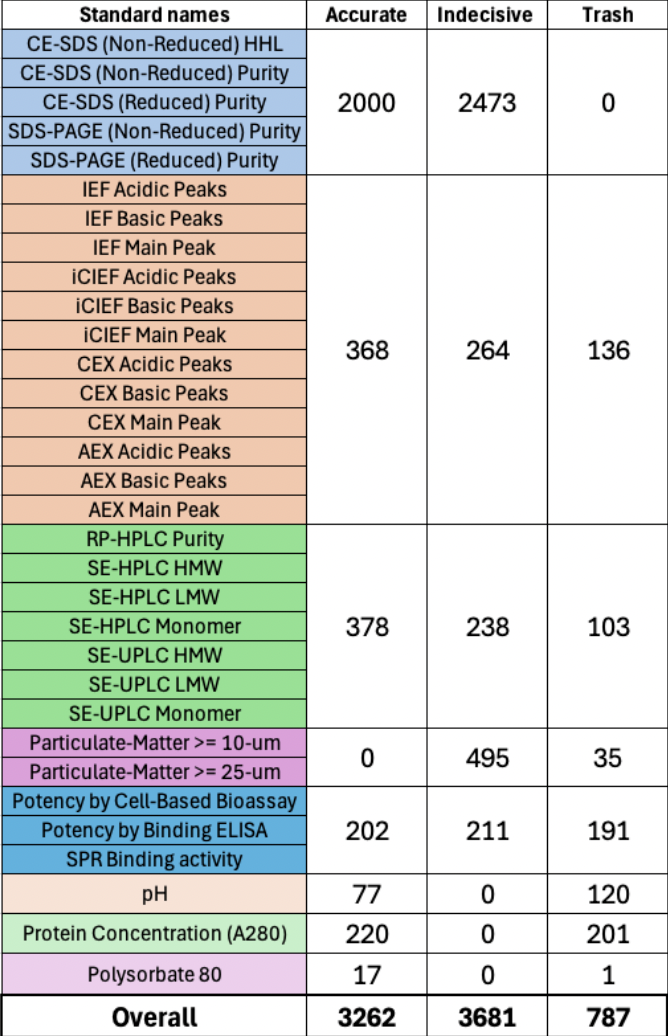
